# Word2Vec model of CogSci data


gensim word2vec takes list of sentences as input, very nice for broken data.

Questions:
- how best to combine phrases?
- should words be stemmed?
https://machinelearningmastery.com/clean-text-machine-learning-python/

LATER: build doc2vec model using gensim for doc meaning

All analyses are first done with only cognitive key words for a sparse but cognition-specific model, then it's repeated with all words for a fuller dataset.

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import string, nltk, sys
import numpy as np
import scipy as sp
import pandas as pd
import gensim as gs
from sklearn import metrics, manifold
import umap
import matplotlib.pylab as plt
sys.path.append('../')
import cogont as co
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import colors

pd.set_option('precision', 5)

# Importing data

In [5]:
# import dictionary (cognitive concept word list)
terms_file = '../data/cogatlas_terms.txt'
terms = pd.read_csv(terms_file, delimiter='\n', names=['Terms'])

# import data as pd dataframe
#abstract_file = '../data/abstracts_cogsci_combined.csv'
#abstract_file = '../data/abstracts_nips_combined.csv'
#abstract_file = '../data/abstracts_cns_combined.csv'
abstract_file = '../data/abstracts_cosyne_scraped_combined.csv'

df_cs = pd.read_csv(abstract_file, header=0, index_col=False, usecols=['Year', 'Title', 'Abstract'], na_filter=True)
print('%i documents extracted. %i with title and abstracts.' %(len(df_cs),len(df_cs.dropna())))

5020 documents extracted. 0 with title and abstracts.


In [29]:
# convert to sentence level representation
print('Converting to sentence-level representation.')
cs_stcs = co.doc_to_stcs(df_cs)
cs_stcs, terms_concat = co.concat_terms(cs_stcs, terms['Terms'].values)

# build gensim word2vec model
print('Training word2vec model.')
cs_w2v = gs.models.Word2Vec(cs_stcs, min_count=2, size=100, window=10, sg=1)
cs_w2v_vocab = cs_w2v.wv.index2word # get the vocab of word2vec representation
cs_vecs = cs_w2v.wv.vectors

Converting to sentence-level representation.
Training word2vec model.


### Search for similarity 
###### In whole dictionary and cognitive terms-only.
below includes a custom most_similar function that restricts the search in a provided dictionary, in this case, the subset of cognitive terms

Note that the custom function can in theory be applied to LSA word vectors as well

In [30]:
# do some queries with the model most_similar function, which looks at the whole corpus
top_n = 10
co.print_similarity(cs_w2v.wv.most_similar(positive=['learning', 'categorization'], topn=top_n))
co.print_similarity(cs_w2v.wv.most_similar(positive=['learning'], negative=['categorization'], topn=top_n))

# co.print_similarity(cs_w2v.wv.most_similar(positive=['dopamine'], negative=['learning'], topn=top_n))
# co.print_similarity(cs_w2v.wv.most_similar(positive=['dopamine'], negative=['brain'], topn=top_n))

----------------
 Similiarty
---------------
0.7163: shape-recognition
0.6979: learners
0.6914: reasoning
0.6905: imagery
0.6851: cue-response
0.6842: posses
0.6811: instrumental-learning
0.6803: object-categorization
0.6763: neurophysiologically
0.6727: stimulus-outcome
----------------
 Similiarty
---------------
0.3315: hesam
0.3268: stdp
0.3229: wulfram
0.3176: savings
0.3075: costa1
0.3056: moritz
0.3043: development
0.3027: setareh
0.3003: ponte
0.2991: gate


In [31]:
# compare most similar terms in the whole corpus vs. subset of CogAtlas terms
top_n=10
positive = ['working-memory']
negative = []
negative = ['attention']

print('\n--- Search in whole corpus: ---')
co.print_similarity(cs_w2v.wv.most_similar(positive=positive, negative=negative, topn=top_n))

print('\n--- Search only the cognitive terms: ---')
co.print_similarity(co.most_similar_subset(cs_w2v_vocab,terms_concat,cs_vecs,positive,negative,top_n))

# more fun examples
# positive = ['representation', 'memory']
# negative = []
# co.print_similarity(most_similar_subset(cs_w2v_vocab,terms_concat,cs_vecs,positive,negative,top_n))

# positive = ['representation']
# negative = ['memory']
# co.print_similarity(most_similar_subset(cs_w2v_vocab,terms_concat,cs_vecs,positive,negative,top_n))


--- Search in whole corpus: ---
----------------
 Similiarty
---------------
0.4237: kevin
0.3744: sussillo
0.3611: 01gq1106
0.3514: wm
0.3351: parametric
0.3292: miller1
0.3262: storage
0.3246: larry
0.3240: associative
0.3231: misha

--- Search only the cognitive terms: ---
----------------
 Similiarty
---------------
0.5670: working-memory
0.3258: maintenance
0.3126: long-term-memory
0.2910: retention
0.2889: memory
0.2826: planning
0.2775: speech-production
0.2711: retrieval
0.2479: context-dependent
0.2458: motor-control


In [32]:
# prediction based on context, this is kinda hilarious
query_stc = 'cognitive neuroscience is'.split()
co.print_similarity(cs_w2v.predict_output_word(query_stc,topn=20))

----------------
 Similiarty
---------------
0.0032: neuroscience
0.0024: cognitive
0.0012: fundamental
0.0011: systems
0.0008: understanding
0.0008: computational
0.0008: programme
0.0007: challenge
0.0007: centre
0.0007: decision-making
0.0007: working-memory
0.0007: understand
0.0007: unknown
0.0007: essential
0.0006: champalimaud
0.0006: crucial
0.0006: key
0.0006: ubiquitous
0.0006: institute
0.0006: academy


# Term similarity matrix from the word vectors

Term Similarity Matrix: (326, 326)


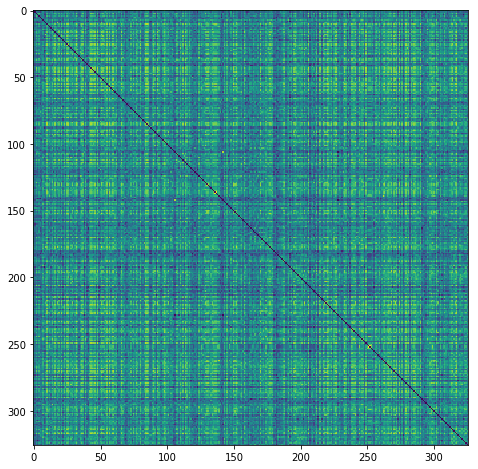

In [33]:
subset_inds = co.return_subset_inds(cs_w2v_vocab, terms_concat)
cs_term_sim = metrics.pairwise.cosine_similarity(cs_vecs[subset_inds])
print('Term Similarity Matrix: (%i, %i)'%cs_term_sim.shape)
plt.figure(figsize=(8,8))
plt.imshow(cs_term_sim - np.eye(cs_term_sim.shape[0]))

# 2D Visualization (via TSNE)

In [36]:
# compute subset indices for cognitive terms
cs_w2v_tsne = manifold.TSNE(n_components=2)
cs_wv_2d = cs_w2v_tsne.fit_transform(cs_vecs[subset_inds])
# cs_wv_2d = cs_w2v_tsne.fit_transform(cs_vecs)

([], <a list of 0 Text yticklabel objects>)

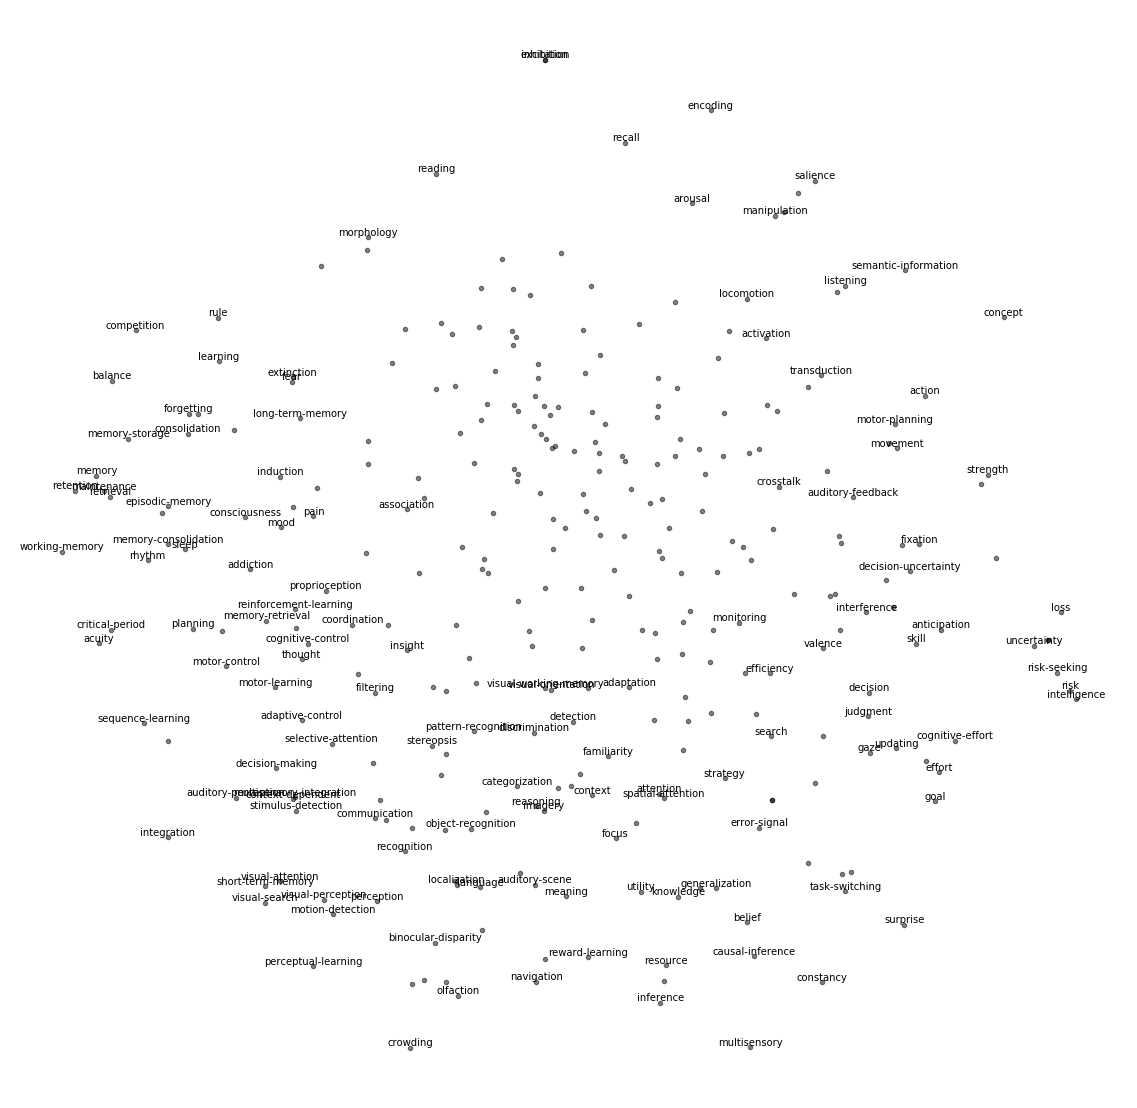

In [37]:
count_thresh = 20
plt.figure(figsize=(20,20))
plt.scatter(cs_wv_2d[:,0], cs_wv_2d[:,1], s=20, c='k', alpha=0.5)
for i,w in enumerate(cs_wv_2d):
    if cs_w2v.wv.vocab[cs_w2v_vocab[subset_inds[i]]].count>count_thresh:
        plt.text(w[0], w[1], cs_w2v_vocab[subset_inds[i]], ha="center", va="bottom", rotation=0)
    
plt.box('off');plt.xticks([]);plt.yticks([])
#plt.savefig('../figures/cs_wv_tsne.png')

# Hierarchical Clustering on Word Vectors

###### can also run word2vec with just corpus words, but that's probably too little data 
I think this basically just grabs co-occurrence, but it seems that the vector arithmetics still "work"

In [41]:
corpus_terms # renamed as docs_as_terms
# get gensim model
model_reduced = gs.models.Word2Vec(corpus_terms, min_count=1, size=200, window=5, sg=1)
model_reduced.wv.most_similar(positive=['learning'], negative=['categorization'], topn=20)

[('domain specificity', 0.052657343447208405),
 ('creative cognition', 0.03384580835700035),
 ('cognitive dissonance', 0.03358886018395424),
 ('perceptual binding', 0.02431131899356842),
 ('object-based attention', 0.021590828895568848),
 ('word generation', 0.012599781155586243),
 ('language acquisition', 0.008719602599740028),
 ('oddball detection', 0.008435919880867004),
 ('language', 0.008409757167100906),
 ('interoception', 0.0030625611543655396),
 ('story comprehension', 0.0009637679904699326),
 ('word pronunciation', 0.0009134011343121529),
 ('visual orientation', 0.0006997324526309967),
 ('language production', 0.0004796832799911499),
 ('skepticism', 0.0003247801214456558),
 ('language processing', -0.0005148239433765411),
 ('conflict adaptation effect', -0.0005677049048244953),
 ('lexicon', -0.0006438568234443665),
 ('animacy perception', -0.0008073663339018822),
 ('saccadic eye movement', -0.0011958228424191475)]

# load pretrained GoogleNews word vectors

In [25]:
# this will take some time and memory
gnews_data_file = '/Users/rdgao/Documents/data/IdentityCrisis/GoogleNews-vectors-negative300.bin.gz'
model_gnews = gs.models.KeyedVectors.load_word2vec_format(gnews_data_file, binary=True)

In [26]:
# precompute subset indices
subset_inds = np.sort([model_gnews.index2word.index(t) for t in terms['Terms'] if t in model_gnews.index2word]) 

In [27]:
# full search has too many garbage words, need to prune to a smaller subset
# maybe only the cognitive terms, or even the whole vocab from cogsci
topn=10
positive = ['representation', 'memory']
#positive = ['memory','categorization']
negative = []
#negative = ['categorization']
# print('\n--- Search in whole corpus: ---')
# print_similarity(model_gnews.most_similar(positive=positive, negative=negative, topn=topn))

print('\n--- Search only the cognitive terms: ---')
print_similarity(most_similar_subset(model_gnews.index2word,subset_inds,model_gnews.vectors,positive,negative,topn))

positive = ['representation']
negative = ['memory']
print_similarity(most_similar_subset(model_gnews.index2word,subset_inds,model_gnews.vectors,positive,negative,topn))


--- Search only the cognitive terms: ---
Using precomputed subset indices...
----------------
Cosine Similiarty
---------------
0.7448: memory
0.3708: recognition
0.3191: consciousness
0.3128: perception
0.2843: communication
0.2830: logic
0.2817: encoding
0.2799: knowledge
0.2717: imagery
0.2717: reconsolidation
Using precomputed subset indices...
----------------
Cosine Similiarty
---------------
0.2130: action
0.1928: discrimination
0.1844: articulation
0.1688: deliberation
0.1540: prejudice
0.1452: coordination
0.1329: resource
0.1272: localization
0.1232: recognition
0.1188: expertise
